In [33]:
# Cell 1: Environment Setup
!pip install -q langchain-groq langchain qdrant-client mlflow python-dotenv sentence-transformers matplotlib seaborn

import os
import warnings
warnings.filterwarnings('ignore')

# Set environment variables
os.environ["USER_AGENT"] = "rag-implementation"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["GROQ_API_KEY"] = "Type your Groq API"  # Replace with your key

print("1. Environment Setup - Complete!")


1. Environment Setup - Complete!


In [34]:
# Cell 2: Initialize Core Components
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
import mlflow

# Initialize LLM with Groq
llm = ChatGroq(
    groq_api_key=os.environ["GROQ_API_KEY"],
    model_name="mixtral-8x7b-32768"
)

# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

# Set up MLflow
mlflow.set_experiment("rag_system")

print("2. Core Components Initialized!")

2. Core Components Initialized!


In [35]:
# Cell 3: Document Processing
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

# Create test document
test_content = """
AI is transforming various industries in significant ways:
1. In healthcare, AI improves diagnosis accuracy and patient care
2. In finance, AI enhances fraud detection and trading systems
3. In education, AI enables personalized learning experiences
4. In manufacturing, AI optimizes production processes
"""

def process_documents(text_content):
    documents = [Document(page_content=text_content, metadata={"source": "test"})]
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
    )
    return text_splitter.split_documents(documents)

documents = process_documents(test_content)
print("3. Document Processing - Complete!")


3. Document Processing - Complete!


In [36]:
# Cell 4: Retrieval System Setup
from langchain.vectorstores import Qdrant
from langchain.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

class EnhancedRetriever:
    def __init__(self, llm, embeddings, documents):
        # Vector store
        self.qdrant = Qdrant.from_documents(
            documents=documents,
            embedding=embeddings,
            location=":memory:",
            collection_name="test_store"
        )
        
        # Base retrievers
        self.bm25 = BM25Retriever.from_documents(documents)
        self.vector_retriever = self.qdrant.as_retriever(search_kwargs={"k": 3})
        
        # Hybrid retriever
        self.hybrid_retriever = EnsembleRetriever(
            retrievers=[self.bm25, self.vector_retriever],
            weights=[0.5, 0.5]
        )
        
        # Reranking
        self.compressor = LLMChainExtractor.from_llm(llm)
        self.reranked_retriever = ContextualCompressionRetriever(
            base_compressor=self.compressor,
            base_retriever=self.hybrid_retriever
        )
    
    def get_relevant_documents(self, query, method="hybrid"):
        retrievers = {
            "vector": self.vector_retriever,
            "bm25": self.bm25,
            "hybrid": self.hybrid_retriever,
            "reranked": self.reranked_retriever
        }
        return retrievers[method].get_relevant_documents(query)

retriever = EnhancedRetriever(llm, embeddings, documents)
print("4. Retrieval System - Complete!")

4. Retrieval System - Complete!


In [37]:
# Cell 5: Workflow Implementation
from langchain.chains import RetrievalQA
import time
import matplotlib.pyplot as plt

class RAGWorkflow:
    def __init__(self, llm, retriever):
        self.llm = llm
        self.retriever = retriever
        self.qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever.hybrid_retriever,
            return_source_documents=True
        )
        self.metrics = []
        
    def process_query(self, query, method="hybrid"):
        try:
            start_time = time.time()
            docs = self.retriever.get_relevant_documents(query, method)
            response = self.qa_chain.invoke(query)
            execution_time = time.time() - start_time
            
            metrics_dict = {
                "execution_time": execution_time,
                "num_docs": float(len(docs))
            }
            
            self.metrics.append({
                "method": method,
                "execution_time": execution_time,
                "success": True,
                "num_docs": len(docs)
            })
            
            with mlflow.start_run(nested=True):
                mlflow.log_param("query", query)
                mlflow.log_param("method", method)
                mlflow.log_metrics(metrics_dict)
            
            return response, metrics_dict
            
        except Exception as e:
            print(f"Error processing query: {str(e)}")
            return None, {"execution_time": 0.0, "num_docs": 0.0}
    
    def plot_metrics(self):
        if not self.metrics:
            print("No metrics available for visualization")
            return
            
        plt.figure(figsize=(10, 6))
        method_times = {}
        for m in self.metrics:
            method = m['method']
            if method not in method_times:
                method_times[method] = []
            method_times[method].append(m['execution_time'])
        
        methods = list(method_times.keys())
        avg_times = [sum(times)/len(times) for times in method_times.values()]
        
        plt.bar(methods, avg_times)
        plt.title('Average Response Time by Method')
        plt.xlabel('Method')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        total_queries = len(self.metrics)
        successful_queries = sum(1 for m in self.metrics if m['success'])
        print(f"\nTotal Queries: {total_queries}")
        print(f"Successful Queries: {successful_queries}")
        print(f"Success Rate: {(successful_queries/total_queries)*100:.2f}%")

print("5. Workflow Implementation - Complete!")


5. Workflow Implementation - Complete!



Testing system with different retrieval methods...

Testing vector method:
Query: What industries is AI transforming?
Response: Based on the given context, AI is transforming the following industries: healthcare, finance, education, and manufacturing. In healthcare, AI improves diagnosis accuracy and patient care. In finance, AI enhances fraud detection and trading systems. In education, AI enables personalized learning experiences. In manufacturing, AI optimizes production processes.
Execution time: 0.91s
Number of documents: 1.0

Testing bm25 method:
Query: What industries is AI transforming?
Response: AI is transforming various industries, including healthcare, finance, education, and manufacturing. In healthcare, AI improves diagnosis accuracy and patient care. In finance, AI enhances fraud detection and trading systems. In education, AI enables personalized learning experiences. In manufacturing, AI optimizes production processes.
Execution time: 0.44s
Number of documents: 1.0

T

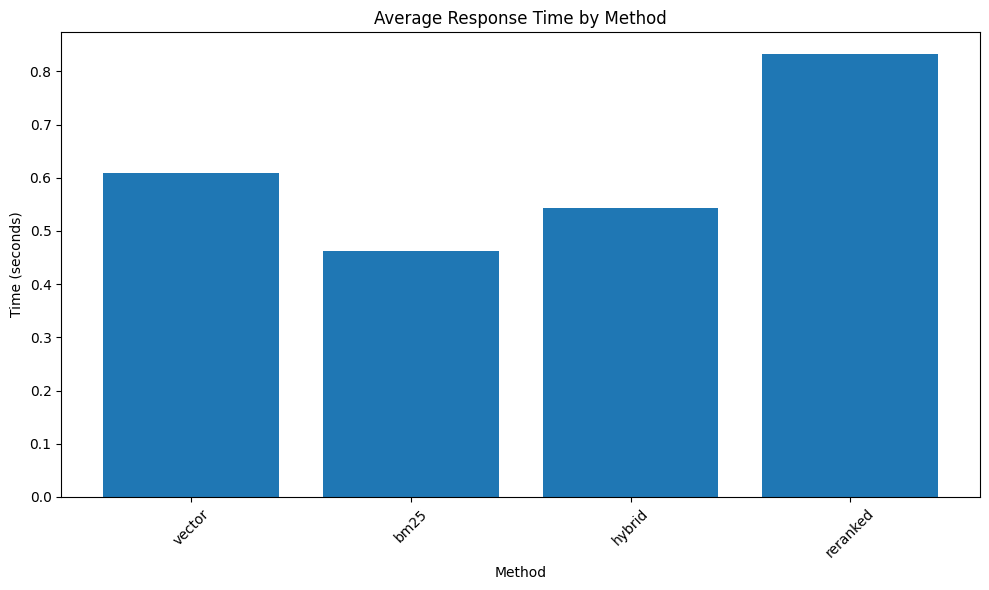


Total Queries: 12
Successful Queries: 12
Success Rate: 100.00%

System testing complete!


In [38]:
# Cell 6: Run the System
def test_system():
    # Initialize workflow
    workflow = RAGWorkflow(llm, retriever)

    # Test queries
    test_queries = [
        "What industries is AI transforming?",
        "How is AI used in healthcare?",
        "What is AI's role in finance?"
    ]

    # Test different methods
    methods = ["vector", "bm25", "hybrid", "reranked"]

    print("\nTesting system with different retrieval methods...")

    for query in test_queries:
        for method in methods:
            print(f"\nTesting {method} method:")
            response, metrics = workflow.process_query(query, method)
            if response:
                print(f"Query: {query}")
                print(f"Response: {response['result']}")
                print(f"Execution time: {metrics['execution_time']:.2f}s")
                print(f"Number of documents: {metrics['num_docs']}")

    # Generate visualizations
    print("\nGenerating performance visualizations...")
    workflow.plot_metrics()

    print("\nSystem testing complete!")

# Run the test
test_system()